# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.mean_test_roc_auc
    test_scores_std = df.std_test_roc_auc
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [6]:
train = pd.read_parquet('./dataset/train_agg_full.parquet.gzip') 
test = pd.read_parquet('./dataset/test_agg_full.parquet.gzip') 

In [7]:
train.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2014-01-24 09:30:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397099.0,74.800278,0.000019,74.80025,74.80031,-300917.8,0.0,-300917.8,-300917.8,1.0
1,WELL-00001,2014-01-24 09:35:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397272.0,74.800168,0.000046,74.80009,74.80025,-300917.8,0.0,-300917.8,-300917.8,1.0
2,WELL-00001,2014-01-24 09:40:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397446.0,74.800010,0.000047,74.79993,74.80009,-300917.8,0.0,-300917.8,-300917.8,1.0
3,WELL-00001,2014-01-24 09:45:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397621.0,74.799852,0.000047,74.79977,74.79993,-300917.8,0.0,-300917.8,-300917.8,1.0
4,WELL-00001,2014-01-24 09:50:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397795.0,74.799693,0.000047,74.79961,74.79977,-300917.8,0.0,-300917.8,-300917.8,1.0


In [8]:
test.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
376538,WELL-00001,2017-08-23 19:40:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.686840e+06,6237.435951,9675544.0,9695493.0,...,1953795.0,84.367123,0.230657,83.58832,84.70229,-140331.8,0.0,-140331.8,-140331.8,0.0
376539,WELL-00001,2017-08-23 19:45:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.691381e+06,7063.428971,9679208.0,9703555.0,...,1950179.0,83.149974,0.159885,82.87943,83.56806,-140331.8,0.0,-140331.8,-140331.8,0.0
376540,WELL-00001,2017-08-23 19:50:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.710671e+06,3047.495846,9703636.0,9715443.0,...,1798996.0,83.693227,0.168539,83.40104,83.95795,-140331.8,0.0,-140331.8,-140331.8,0.0
376541,WELL-00001,2017-08-23 19:55:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.700290e+06,5400.736360,9683720.0,9708045.0,...,1835164.0,83.880155,0.040774,83.80988,83.95042,-140331.8,0.0,-140331.8,-140331.8,0.0
376542,WELL-00001,2017-08-23 20:00:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.687219e+06,5027.774671,9675544.0,9695493.0,...,1937881.0,83.739377,0.040907,83.66887,83.80942,-140331.8,0.0,-140331.8,-140331.8,0.0


In [9]:
train.target.value_counts()

target
0.0    22051
1.0    10887
Name: count, dtype: int64

In [10]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(32938, 27)

In [11]:
validation = test.reset_index(drop=True)
validation.shape

(8241, 27)

In [12]:
validation.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2017-08-23 19:40:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.686840e+06,6237.435951,9675544.0,9695493.0,...,1953795.0,84.367123,0.230657,83.58832,84.70229,-140331.8,0.0,-140331.8,-140331.8,0.0
1,WELL-00001,2017-08-23 19:45:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.691381e+06,7063.428971,9679208.0,9703555.0,...,1950179.0,83.149974,0.159885,82.87943,83.56806,-140331.8,0.0,-140331.8,-140331.8,0.0
2,WELL-00001,2017-08-23 19:50:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.710671e+06,3047.495846,9703636.0,9715443.0,...,1798996.0,83.693227,0.168539,83.40104,83.95795,-140331.8,0.0,-140331.8,-140331.8,0.0
3,WELL-00001,2017-08-23 19:55:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.700290e+06,5400.736360,9683720.0,9708045.0,...,1835164.0,83.880155,0.040774,83.80988,83.95042,-140331.8,0.0,-140331.8,-140331.8,0.0
4,WELL-00001,2017-08-23 20:00:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.687219e+06,5027.774671,9675544.0,9695493.0,...,1937881.0,83.739377,0.040907,83.66887,83.80942,-140331.8,0.0,-140331.8,-140331.8,0.0


In [13]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [14]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(22051, 27)

In [15]:
feature_model = [col for col in train.columns if col not in ['timestamp', 'well', 'target']]
feature_model

['P-PDG_mean',
 'P-PDG_std',
 'P-PDG_min',
 'P-PDG_max',
 'P-TPT_mean',
 'P-TPT_std',
 'P-TPT_min',
 'P-TPT_max',
 'T-TPT_mean',
 'T-TPT_std',
 'T-TPT_min',
 'T-TPT_max',
 'P-MON-CKP_mean',
 'P-MON-CKP_std',
 'P-MON-CKP_min',
 'P-MON-CKP_max',
 'T-JUS-CKP_mean',
 'T-JUS-CKP_std',
 'T-JUS-CKP_min',
 'T-JUS-CKP_max',
 'P-JUS-CKGL_mean',
 'P-JUS-CKGL_std',
 'P-JUS-CKGL_min',
 'P-JUS-CKGL_max']

In [16]:
development

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2014-01-24 09:30:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397099.0,74.800278,0.000019,74.80025,74.80031,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
1,WELL-00001,2014-01-24 09:35:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397272.0,74.800168,0.000046,74.80009,74.80025,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
2,WELL-00001,2014-01-24 09:40:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397446.0,74.800010,0.000047,74.79993,74.80009,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
3,WELL-00001,2014-01-24 09:45:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397621.0,74.799852,0.000047,74.79977,74.79993,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
4,WELL-00001,2014-01-24 09:50:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397795.0,74.799693,0.000047,74.79961,74.79977,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32933,WELL-00018,2019-04-03 09:40:00,0.0,0.0,0.0,0.0,8.431093e+06,712.726134,8429578.0,8432542.0,...,1483602.0,74.213973,0.110205,74.00000,74.36111,9.397205e+06,4166.921226,9390495.0,9404494.0,1.0
32934,WELL-00018,2019-04-03 09:45:00,0.0,0.0,0.0,0.0,8.430980e+06,678.090498,8429752.0,8432400.0,...,1457574.0,74.000000,0.000000,74.00000,74.00000,9.410833e+06,5949.398514,9404543.0,9427083.0,1.0
32935,WELL-00018,2019-04-03 09:50:00,0.0,0.0,0.0,0.0,8.430743e+06,911.513084,8429560.0,8433425.0,...,1457574.0,74.000000,0.000000,74.00000,74.00000,9.427372e+06,1767.329397,9427083.0,9442866.0,1.0
32936,WELL-00018,2019-04-03 09:55:00,0.0,0.0,0.0,0.0,8.430795e+06,485.347977,8429913.0,8432119.0,...,1474926.0,74.000000,0.000000,74.00000,74.00000,9.444548e+06,340.325177,9444444.0,9446233.0,1.0


In [17]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [18]:
y_dev.sum()

10887.0

In [19]:
len(y_dev)

32938

In [20]:
X_no_anomalies = train_no_anomalies[feature_model].values

### Optimization with TPE (Tree-Structured Parzen Estimator)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [74]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

In [ ]:
def build_iforest(params):
    estimator = IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

def transform_iforest_params(params):
    return {
        'n_estimators': int(params[0]),
        'contamination': float(params[1]),
        'max_samples': float(params[2]),
        'max_features': float(params[3])
    }

def evaluate_model(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def objective_iforest(trial, dataset, tscv, features):
    n_estimators = trial.suggest_int('n_estimators', 5, 256)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    max_samples = trial.suggest_float('max_samples', 0.3, 1.0)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    params = [n_estimators, contamination, max_samples, max_features]

    model_params = transform_iforest_params(params)
    model = build_iforest(model_params)

    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_iforest(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_iforest(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [94]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

In [95]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_iforest, study_iforest = optuna_optimization_iforest(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para Isolation Forest: {best_params_iforest}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-05-04 00:21:43,069] A new study created in memory with name: no-name-6d359f22-7500-4ccc-b6cd-85c670aab886
[I 2025-05-04 00:21:46,699] Trial 0 finished with value: 15.785238927826818 and parameters: {'n_estimators': 191, 'contamination': 0.0010278810088418478, 'max_samples': 0.36264580542947183, 'max_features': 0.5103611089189933}. Best is trial 0 with value: 15.785238927826818.
[I 2025-05-04 00:21:47,632] Trial 1 finished with value: 31.82107093157708 and parameters: {'n_estimators': 35, 'contamination': 0.0037019529220385454, 'max_samples': 0.9964871015282435, 'max_features': 0.751865391931213}. Best is trial 1 with value: 31.82107093157708.
[I 2025-05-04 00:21:55,497] Trial 2 finished with value: 17.867310877999138 and parameters: {'n_estimators': 242, 'contamination': 0.004911435027356309, 'max_samples': 0.8192640037292047, 'max_features': 0.4901316718938463}. Best is trial 1 with value: 31.82107093157708.
[I 2025-05-04 00:21:55,922] Trial 3 finished with value: 31.868900248

Melhores parâmetros para Isolation Forest: {'n_estimators': 5, 'contamination': 0.004540424186858893, 'max_samples': 0.9768741350235296, 'max_features': 0.6639293063953297}

--- Resultados Finais ---
Tempo total de execução: 808.58 segundos
Tempo total de execução: 13.48 minutos


In [100]:
data_metrics_iforest = []

for trial in study_iforest.trials:
    data_metrics_iforest.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_iforest = pd.DataFrame(data_metrics_iforest)
df_results_iforest.to_csv('./metrics_anomaly_detection/results_iforest_tpe.csv', index=False)
df_results_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.564991,0.407139,15.785239,191,0.001028,0.362646,0.510361
1,1,0.689712,0.371502,31.821071,35,0.003702,0.996487,0.751865
2,2,0.594817,0.416144,17.867311,242,0.004911,0.819264,0.490132
3,3,0.671598,0.352909,31.868900,17,0.004015,0.916257,0.355029
4,4,0.586254,0.414619,17.163534,204,0.003180,0.479846,0.372409


In [21]:
df_results_iforest = pd.read_csv('./metrics_anomaly_detection/results_iforest_tpe.csv')   

df_results_iforest['roc_auc_adjusted'] = df_results_iforest['roc_auc_mean'] - df_results_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_iforest.loc[999]
best_params = df_results_iforest.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               810.000000
roc_auc_mean          0.755599
roc_auc_std           0.225249
value                53.035032
n_estimators          5.000000
contamination         0.004540
max_samples           0.976874
max_features          0.663929
roc_auc_adjusted      0.530350
Name: 810, dtype: float64


In [ ]:
best_params_iforest 

{'n_estimators': 5,
 'contamination': 0.004540424186858893,
 'max_samples': 0.9768741350235296,
 'max_features': 0.6639293063953297}

In [21]:
best_params_iforest = {'n_estimators': 5,
 'contamination': 0.004540424186858893,
 'max_samples': 0.9768741350235296,
 'max_features': 0.6639293063953297}

In [22]:
n_estimators_best = int(best_params_iforest.get('n_estimators'))
contamination_best = round(float(best_params_iforest.get('contamination')), 5)
max_samples_best = round(float(best_params_iforest.get('max_samples')), 2)
max_features_best = round(float(best_params_iforest.get('max_features')), 2)

In [23]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    random_state=42
)

pipe_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 IsolationForest(contamination=0.00454, max_features=0.66,
                                 max_samples=0.98, n_estimators=5,
                                 random_state=42))])

In [24]:
scores_dev = -pipe_model_iforest.decision_function(X_dev)
final_auc = roc_auc_score(y_dev, scores_dev)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_dev, scores_dev)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9857


In [25]:
y_pred = pipe_model_iforest.predict(X_dev)
y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.92843   0.99542   0.96076     22051
         1.0    0.98914   0.84459   0.91116     10887

    accuracy                        0.94556     32938
   macro avg    0.95878   0.92000   0.93596     32938
weighted avg    0.94850   0.94556   0.94437     32938

Specificity: 0.9954197088567411
Gini:  0.8400049940592764
ROC AUC::  0.9200024970296382


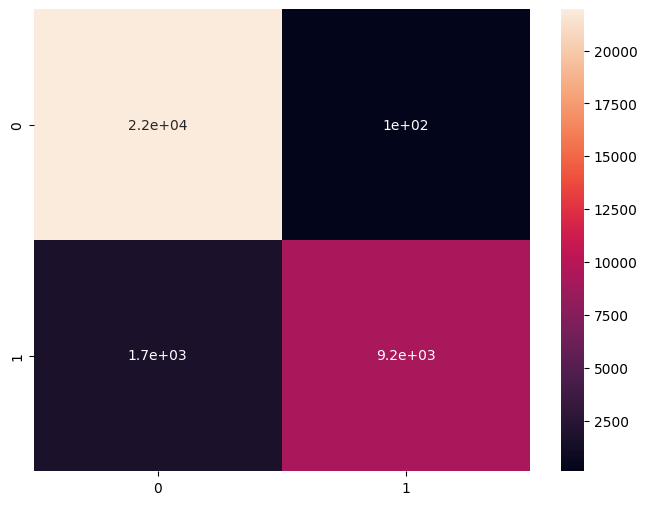

In [26]:
metrics(y_dev, y_pred)

In [27]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [28]:
# scores_valid = -best_model_iforest.decision_function(X_valid)
# y_pred = (scores_valid >= best_threshold).astype(int)
y_pred = pipe_model_iforest.predict(X_valid)
y_pred = np.where(y_pred == -1, 1, 0)  

In [29]:
scores_valid = -pipe_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9386


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.96563   0.81418   0.88347      5936
         1.0    0.65915   0.92538   0.76990      2305

    accuracy                        0.84529      8241
   macro avg    0.81239   0.86978   0.82668      8241
weighted avg    0.87991   0.84529   0.85170      8241

Specificity: 0.8141846361185984
Gini:  0.7395642456630669
ROC AUC::  0.8697821228315334


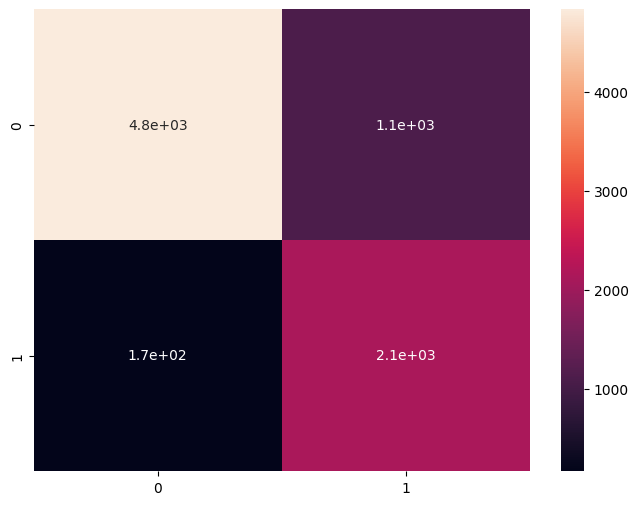

In [30]:
metrics(y_valid, y_pred)

In [31]:
scores = -pipe_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores)

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9386


In [32]:
validation['scores_forest']=-pipe_model_iforest.decision_function(X_valid)

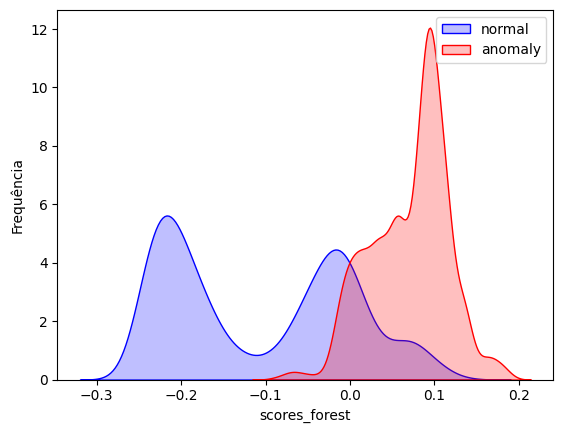

In [33]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [34]:
with open('./models/pipeline_iForest_tpe.pkl', 'wb') as file: 
    pickle.dump(pipe_model_iforest, file)

In [415]:
# with open('./models/pipeline_iForest_RL.pkl', 'rb') as f:
#     iforest_old = pickle.load(f) 

# iforest_old

## Local Outlier Factor

In [118]:
from sklearn.neighbors import LocalOutlierFactor

In [119]:
def build_lof(params):
    model = LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_lof_params(params):
    return {
        'n_neighbors': int(params[0]),
        'contamination': float(params[1])
    }

def objective_lof(trial, dataset, tscv, features):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    params = [n_neighbors, contamination]

    model_params = transform_lof_params(params)
    model = build_lof(model_params)

    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_lof(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_lof(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [120]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_lof, study_lof = optuna_optimization_lof(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para LOF: {best_params_lof}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-05-04 01:14:27,051] A new study created in memory with name: no-name-a822ad50-c076-490e-92a4-ef76bbe71319
[I 2025-05-04 01:14:37,004] Trial 0 finished with value: 42.99702987789142 and parameters: {'n_neighbors': 25, 'contamination': 0.0028855024910298226}. Best is trial 0 with value: 42.99702987789142.
[I 2025-05-04 01:14:44,867] Trial 1 finished with value: 40.287395936844774 and parameters: {'n_neighbors': 12, 'contamination': 0.0011240238058523586}. Best is trial 0 with value: 42.99702987789142.
[I 2025-05-04 01:14:56,578] Trial 2 finished with value: 41.54284628410665 and parameters: {'n_neighbors': 17, 'contamination': 0.0011722979435650832}. Best is trial 0 with value: 42.99702987789142.
[I 2025-05-04 01:15:08,854] Trial 3 finished with value: 32.4987072275619 and parameters: {'n_neighbors': 4, 'contamination': 0.0007538186350199892}. Best is trial 0 with value: 42.99702987789142.
[I 2025-05-04 01:15:23,101] Trial 4 finished with value: 42.446717380528106 and parameters:

Melhores parâmetros para LOF: {'n_neighbors': 25, 'contamination': 0.0028855024910298226}
Tempo total de execução: 7897.05 segundos
Tempo total de execução: 131.62 minutos


In [121]:
data_metrics_lof = []

for trial in study_lof.trials:
    data_metrics_lof.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_lof = pd.DataFrame(data_metrics_lof)
df_results_lof.to_csv('./metrics_anomaly_detection/results_lof_tpe.csv', index=False)
df_results_lof.head()

,trial,roc_auc_mean,roc_auc_std,value,n_neighbors,contamination
0,0,0.675847,0.245877,42.997030,25,0.002886
1,1,0.560133,0.157259,40.287396,12,0.001124
2,2,0.666192,0.250763,41.542846,17,0.001172
3,3,0.588830,0.263843,32.498707,4,0.000754
4,4,0.673182,0.248715,42.446717,21,0.001774


In [22]:
df_results_lof = pd.read_csv('./metrics_anomaly_detection/results_lof_tpe.csv')   

df_results_lof['roc_auc_adjusted'] = df_results_lof['roc_auc_mean'] - df_results_lof['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_lof.loc[999]
best_params = df_results_lof.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                0.000000
roc_auc_mean         0.675847
roc_auc_std          0.245877
value               42.997030
n_neighbors         25.000000
contamination        0.002886
roc_auc_adjusted     0.429970
Name: 0, dtype: float64


In [37]:
best_params_lof = {
 'contamination': 0.002886,
 'n_neighbors': 25}

In [38]:
n_neighbors_best = int(round(best_params_lof.get('n_neighbors'), 0))
contamination_best = round(float(best_params_lof.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=25, contamination=0.00289


In [39]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

estimator_lof 

LocalOutlierFactor(contamination=0.00289, n_jobs=-1, n_neighbors=25,
                   novelty=True)

In [40]:
pipe_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [41]:
pipe_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00289, n_jobs=-1,
                                    n_neighbors=25, novelty=True))])

In [42]:
y_pred = pipe_model_lof.predict(X_dev)
y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.86446   0.99728   0.92613     22051
         1.0    0.99200   0.68329   0.80920     10887

    accuracy                        0.89350     32938
   macro avg    0.92823   0.84029   0.86767     32938
weighted avg    0.90662   0.89350   0.88748     32938

Specificity: 0.9972790349644007
Gini:  0.68057103459699
ROC AUC::  0.840285517298495


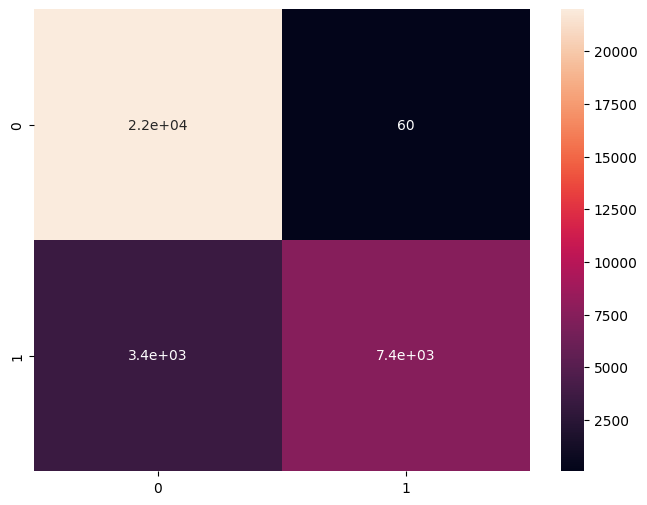

In [43]:
metrics(y_dev, y_pred)

In [44]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [45]:
y_pred = pipe_model_lof.predict(X_valid)
y_pred = np.where(y_pred == -1, 1, 0)  

In [46]:

scores_valid = -pipe_model_lof.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9959


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99678   0.99158   0.99417      5936
         1.0    0.97860   0.99176   0.98513      2305

    accuracy                        0.99163      8241
   macro avg    0.98769   0.99167   0.98965      8241
weighted avg    0.99170   0.99163   0.99164      8241

Specificity: 0.991576819407008
Gini:  0.983333869298548
ROC AUC::  0.991666934649274


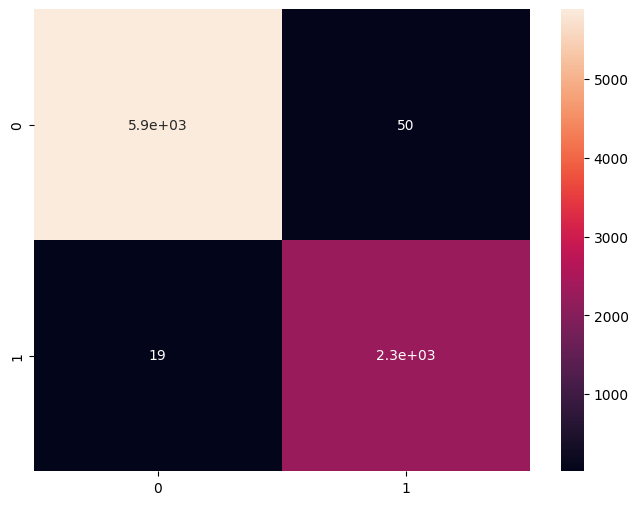

In [47]:
metrics(y_valid, y_pred)

In [48]:
with open('./models/pipeline_LOF_tpe.pkl', 'wb') as file: 
    pickle.dump(pipe_model_lof, file)

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [ ]:
def evaluate_model_pyod(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

#### PCA

In [134]:
from pyod.models.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo PCA com pipeline
def build_pca(params):
    model = PCA(
        contamination=params['contamination'], 
        n_components=params['n_components']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Transformação de vetor para dicionário de parâmetros
def transform_pca_params(params):
    return {
        'contamination': float(params[0]), 
        'n_components': float(params[1])
    }

# Função objetivo do Optuna
def objective_pca(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_components = trial.suggest_float('n_components', 0.5, 1.0)

    # Parâmetros como vetor para função de transformação
    params = [contamination, n_components]
    model_params = transform_pca_params(params)

    model = build_pca(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com CMA-ES
def optuna_optimization_pca(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_pca(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [135]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_pca, study_pca = optuna_optimization_pca(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para pca: {best_params_pca}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-05-04 03:26:12,773] A new study created in memory with name: no-name-a51103b2-68c3-48ed-92fe-a3487c03da44
[I 2025-05-04 03:26:12,950] Trial 0 finished with value: 9.459254172324282 and parameters: {'contamination': 0.0010070568856889012, 'n_components': 0.5966307982222783}. Best is trial 0 with value: 9.459254172324282.
[I 2025-05-04 03:26:13,115] Trial 1 finished with value: 9.459140487341362 and parameters: {'contamination': 0.004932159405452242, 'n_components': 0.7353298350505748}. Best is trial 0 with value: 9.459254172324282.
[I 2025-05-04 03:26:13,308] Trial 2 finished with value: 9.464264143689904 and parameters: {'contamination': 0.004796090796538127, 'n_components': 0.9074092942222143}. Best is trial 2 with value: 9.464264143689904.
[I 2025-05-04 03:26:13,479] Trial 3 finished with value: 9.459254172324282 and parameters: {'contamination': 0.00038683949236603866, 'n_components': 0.6089535788116405}. Best is trial 2 with value: 9.464264143689904.
[I 2025-05-04 03:26:13,

Melhores parâmetros para pca: {'contamination': 0.0028830001050153676, 'n_components': 0.9994632404726478}
Tempo total de execução: 192.73 segundos
Tempo total de execução: 3.21 minutos


In [136]:
data_metrics_pca = []

for trial in study_pca.trials:
    data_metrics_pca.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_pca = pd.DataFrame(data_metrics_pca)
df_results_pca.to_csv('./metrics_anomaly_detection/results_pca_tpe.csv', index=False)
df_results_pca.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_components
0,0,0.483999,0.389407,9.459254,0.001007,0.596631
1,1,0.483973,0.389382,9.459140,0.004932,0.735330
2,2,0.484052,0.389409,9.464264,0.004796,0.907409
3,3,0.483999,0.389407,9.459254,0.000387,0.608954
4,4,0.484140,0.389412,9.472765,0.000184,0.979506


In [23]:
df_results_pca = pd.read_csv('./metrics_anomaly_detection/results_pca_tpe.csv')   

df_results_pca['roc_auc_adjusted'] = df_results_pca['roc_auc_mean'] - df_results_pca['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_pca.loc[999]
best_params = df_results_pca.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               55.000000
roc_auc_mean         0.484207
roc_auc_std          0.389415
value                9.479173
contamination        0.002883
n_components         0.999463
roc_auc_adjusted     0.094792
Name: 55, dtype: float64


In [50]:
best_params_pca = {'contamination': 0.0028830001050153676, 'n_components': 0.9994632404726478}

In [51]:
best_params_pca 

{'contamination': 0.0028830001050153676, 'n_components': 0.9994632404726478}

In [52]:
n_components_best = int(round(best_params_pca.get('n_components'), 2))
contamination_best = round(float(best_params_pca.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_components={n_components_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_components=1, contamination=0.00288


In [53]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                n_components = n_components_best
                
                )

In [54]:
# estimator = PCA(** best_params_pca, random_state=42)

pipe_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 PCA(contamination=0.00288, copy=True, iterated_power='auto', n_components=1,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False))])

In [55]:
y_pred = pipe_model_pca.predict(development[feature_model])

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.82870   0.99710   0.90513     22051
         1.0    0.99001   0.58253   0.73348     10887

    accuracy                        0.86007     32938
   macro avg    0.90935   0.78981   0.81930     32938
weighted avg    0.88202   0.86007   0.84839     32938

Specificity: 0.9970976372953607
Gini:  0.5796272597808938
ROC AUC::  0.7898136298904469


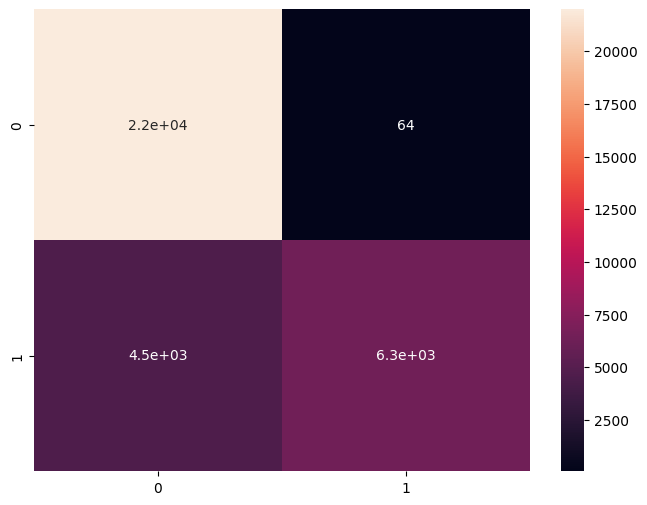

In [56]:
metrics(y_dev, y_pred)

In [57]:
y_pred = pipe_model_pca.predict(validation[feature_model])
y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.95243   0.99175   0.97169      5936
         1.0    0.97621   0.87245   0.92142      2305

    accuracy                        0.95838      8241
   macro avg    0.96432   0.93210   0.94656      8241
weighted avg    0.95909   0.95838   0.95763      8241

Specificity: 0.9917452830188679
Gini:  0.8641964760774361
ROC AUC::  0.932098238038718


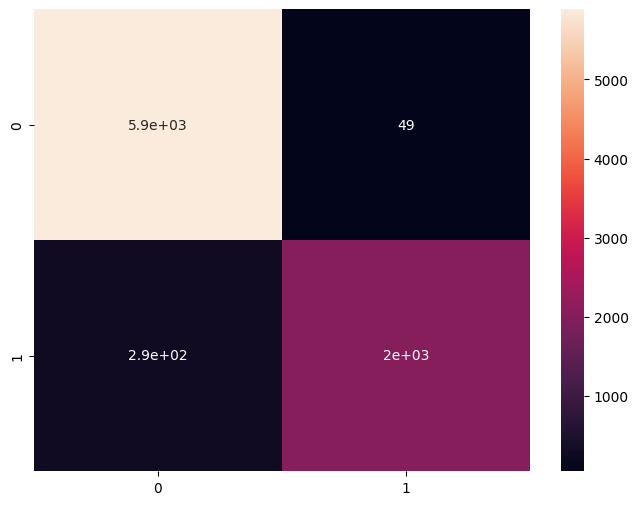

In [58]:
metrics(y_test, y_pred)

In [59]:
with open('./models/pipeline_PCA_tpe.pkl', 'wb') as file: 
    pickle.dump(pipe_model_pca, file)

In [63]:
# with open('./models/pipeline_PCA_RL_old.pkl', 'rb') as f:
#     pca_old = pickle.load(f) 
# pca_old

#### LODA

In [144]:
from pyod.models.loda import LODA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo LODA
def build_loda(params):
    model = LODA(
        contamination=params['contamination'],
        n_bins=params['n_bins'],
        n_random_cuts=params['n_random_cuts']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Função para transformar vetor de parâmetros em dicionário
def transform_loda_params(params):
    return {
        'contamination': float(params[0]),
        'n_bins': int(params[1]),
        'n_random_cuts': int(params[2])
    }

# Função objetivo para o Optuna
def objective_loda(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_bins = trial.suggest_int('n_bins', 50, 5000)
    n_random_cuts = trial.suggest_int('n_random_cuts', 10, 1000)

    params = [contamination, n_bins, n_random_cuts]
    model_params = transform_loda_params(params)
    model = build_loda(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com CmaEsSampler
def optuna_optimization_loda(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_loda(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [145]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_loda, study_loda = optuna_optimization_loda(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para loda: {best_params_loda}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-05-04 03:29:26,811] A new study created in memory with name: no-name-e689931b-00b3-4519-9105-6df15c2a72f4
[I 2025-05-04 03:29:33,029] Trial 0 finished with value: 19.726777596620092 and parameters: {'contamination': 0.0012243867601746446, 'n_bins': 1900, 'n_random_cuts': 760}. Best is trial 0 with value: 19.726777596620092.
[I 2025-05-04 03:29:38,256] Trial 1 finished with value: 33.058957340086195 and parameters: {'contamination': 0.0010054243353443426, 'n_bins': 1519, 'n_random_cuts': 746}. Best is trial 1 with value: 33.058957340086195.
[I 2025-05-04 03:29:41,524] Trial 2 finished with value: 27.970543392580744 and parameters: {'contamination': 0.004702557549013788, 'n_bins': 1090, 'n_random_cuts': 446}. Best is trial 1 with value: 33.058957340086195.
[I 2025-05-04 03:29:48,210] Trial 3 finished with value: 20.30434888743182 and parameters: {'contamination': 0.003692978754153713, 'n_bins': 2922, 'n_random_cuts': 877}. Best is trial 1 with value: 33.058957340086195.
[I 2025-0

Melhores parâmetros para loda: {'contamination': 0.004734695893967369, 'n_bins': 273, 'n_random_cuts': 134}
Tempo total de execução: 1639.27 segundos
Tempo total de execução: 27.32 minutos


In [146]:
data_metrics_loda = []

for trial in study_loda.trials:
    data_metrics_loda.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_loda = pd.DataFrame(data_metrics_loda)
df_results_loda.to_csv('./metrics_anomaly_detection/results_loda_tpe.csv', index=False)
df_results_loda.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_bins,n_random_cuts
0,0,0.629451,0.432183,19.726778,0.001224,1900,760
1,1,0.684010,0.353420,33.058957,0.001005,1519,746
2,2,0.659322,0.379617,27.970543,0.004703,1090,446
3,3,0.623830,0.420787,20.304349,0.003693,2922,877
4,4,0.637699,0.396324,24.137520,0.002706,2886,990


In [24]:
df_results_loda = pd.read_csv('./metrics_anomaly_detection/results_loda_tpe.csv')   

df_results_loda['roc_auc_adjusted'] = df_results_loda['roc_auc_mean'] - df_results_loda['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_loda.loc[999]
best_params = df_results_loda.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               941.000000
roc_auc_mean          0.728105
roc_auc_std           0.268168
value                45.993711
contamination         0.004735
n_bins              273.000000
n_random_cuts       134.000000
roc_auc_adjusted      0.459937
Name: 941, dtype: float64


In [60]:
best_params_loda = {'contamination': 0.004734695893967369, 'n_bins': 273, 'n_random_cuts': 134}

In [61]:
best_params_loda

{'contamination': 0.004734695893967369, 'n_bins': 273, 'n_random_cuts': 134}

In [62]:
n_random_cuts_best = int(best_params_loda.get('n_random_cuts'))
contamination_best = round(float(best_params_loda.get('contamination')), 5)
n_bins_best = int(best_params_loda.get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")


Melhores hiperparâmetros encontrados: n_random_cuts=134, contamination=0.00473, n_bins=273


In [63]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

pipe_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 LODA(contamination=0.00473, n_bins=273, n_random_cuts=134))])

In [64]:
y_pred = pipe_model_loda.predict(validation[feature_model])
y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.96888   0.96513   0.96700      5936
         1.0    0.91108   0.92017   0.91561      2305

    accuracy                        0.95255      8241
   macro avg    0.93998   0.94265   0.94130      8241
weighted avg    0.95272   0.95255   0.95263      8241

Specificity: 0.9651280323450134
Gini:  0.8853015681367704
ROC AUC::  0.9426507840683852


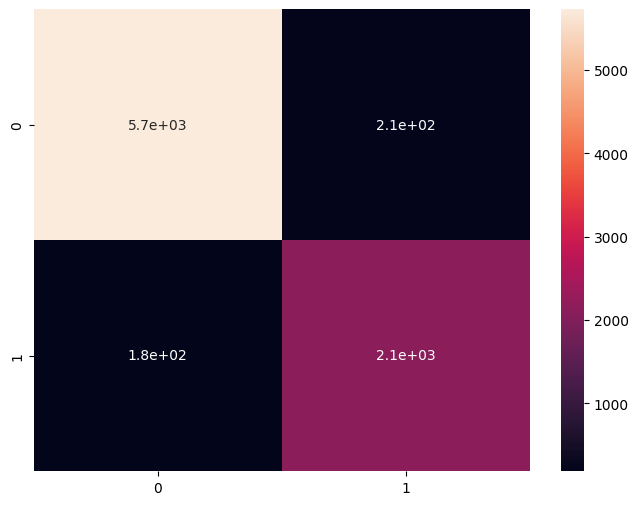

In [65]:
metrics(y_test, y_pred)

In [66]:
y_pred = pipe_model_loda.predict(development[feature_model])

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.94816   0.99524   0.97113     22051
         1.0    0.98928   0.88978   0.93689     10887

    accuracy                        0.96038     32938
   macro avg    0.96872   0.94251   0.95401     32938
weighted avg    0.96175   0.96038   0.95981     32938

Specificity: 0.9952383111877012
Gini:  0.8850151092036838
ROC AUC::  0.9425075546018419


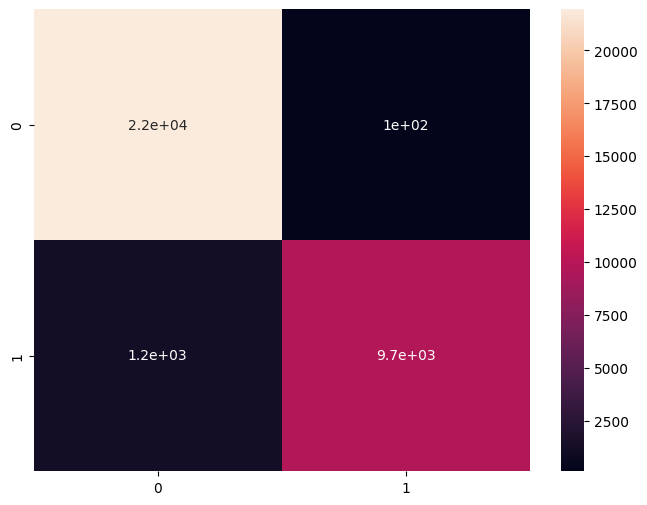

In [67]:
metrics(y_dev, y_pred)

In [68]:
with open('./models/pipeline_LODA_tpe.pkl', 'wb') as file: 
    pickle.dump(pipe_model_loda, file)

### SGDOneClassSVM
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM

In [ ]:
from pyod.models.sgd import SGDOneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna

def build_sgd_svm(params):
    model = SGDOneClassSVM(
        gamma=params['gamma'],
        loss=params['loss'],
        penalty=params['penalty'],
        max_iter=1000
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_sgd_svm_params(params):
    return {
        'gamma': float(params[0]),
        'loss': params[1],
        'penalty': params[2]
    }

def objective_sgd_svm(trial, dataset, tscv, features):
    gamma = trial.suggest_float('gamma', 0.001, 1.0)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    params = [gamma, loss, penalty]

    model_params = transform_sgd_svm_params(params)
    model = build_sgd_svm(model_params)
    score = evaluate_model(model, dataset, tscv, features)
    return score

def optuna_optimization_sgd_svm(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_sgd_svm(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params

In [92]:
param_ranges_svm = {
    'nu': (0.0001, 0.005),
    'eta0': (0.01, 0.1),
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'kernel_type': ['rbf', 'poly', 'linear', 'sigmoid'],
    'gamma': (0.01, 10)
}

In [ ]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params = genetic_optimization_cv(
    model_builder=build_sgd_ocsvm,
    param_ranges=param_ranges_svm,
    dataset=development,
    tscv=tscv,
    features=feature_model,
    ngen=10,
    pop_size=30,
    cxpb=0.5,
    mutpb=0.2
)

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Melhores parâmetros", best_params)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")


Otimizando para kernel = rbf
  → learning_rate = constant
|   iter    |  target   |   eta0    |   gamma   |    nu     |
-------------------------------------------------------------
| 1         | 47.53     | 0.04371   | 9.508     | 0.003687  |
| 2         | 58.61     | 0.06388   | 1.569     | 0.0008644 |
| 3         | 47.47     | 0.01523   | 8.663     | 0.003045  |
| 4         | 71.64     | 0.07373   | 0.2156    | 0.004853  |
| 5         | 53.18     | 0.08492   | 2.131     | 0.0009909 |
| 6         | 72.25     | 0.02528   | 0.01158   | 0.003619  |
| 7         | 71.48     | 0.09423   | 0.01629   | 0.001834  |
| 8         | 50.0      | 0.01161   | 5.487     | 0.0003748 |
| 9         | 72.26     | 0.01036   | 0.1097    | 0.003887  |
| 10        | 54.1      | 0.01081   | 0.596     | 0.00335   |
| 11        | 48.46     | 0.09329   | 3.786     | 0.00224   |
| 12        | 47.57     | 0.09653   | 7.062     | 0.002935  |
| 13        | 47.43     | 0.09867   | 4.659     | 0.004484  |
| 14       

In [160]:
best_sgd_nystroem['params']

{'eta0': 0.06760384164907175,
 'gamma': 0.09391042283938095,
 'nu': 0.000492050213409035,
 'kernel_type': 'rbf',
 'learning_rate': 'adaptive'}

In [162]:
# estimator = SGDOneClassSVM(**best_sgd_nystroem['params'], random_state=42)

In [167]:
estimator = SGDOneClassSVM(
eta0=0.06760384164907175,
nu=0.000492050213409035,
learning_rate='adaptive', random_state=42
 )

transform = Nystroem(gamma=0.09391042283938095,kernel= 'rbf', random_state=42)
estimator = make_pipeline(transform, estimator)

pipe_model_svm = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_svm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 Pipeline(steps=[('nystroem',
                                  Nystroem(gamma=0.09391042283938095,
                                           random_state=42)),
                                 ('sgdoneclasssvm',
                                  SGDOneClassSVM(eta0=0.06760384164907175,
                                                 learning_rate='adaptive',
                                                 nu=0.000492050213409035,
                                                 random_state=42))]))])

In [168]:
y_pred = pipe_model_svm.predict(validation[feature_model])
y_pred = np.where(y_pred == -1, 1, 0)  


y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99008   0.99175   0.99091      5936
         1.0    0.97865   0.97440   0.97652      2305

    accuracy                        0.98689      8241
   macro avg    0.98436   0.98307   0.98372      8241
weighted avg    0.98688   0.98689   0.98689      8241

Specificity: 0.9917452830188679
Gini:  0.9661487537347029
ROC AUC::  0.9830743768673514


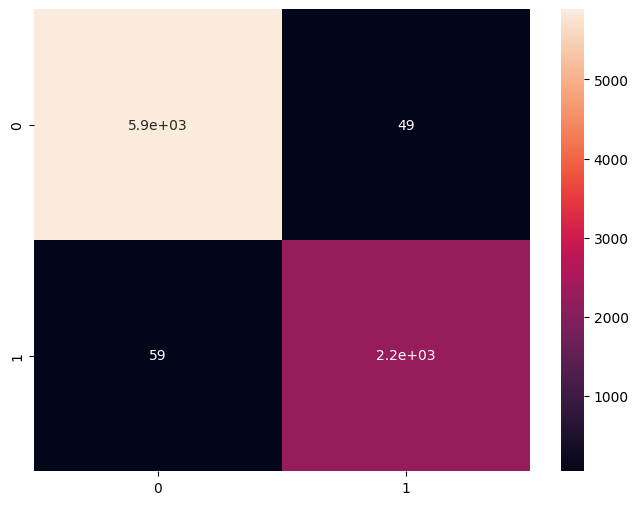

In [169]:
metrics(y_test, y_pred)

In [ ]:
with open('./models/pipeline_SGDOSVM_tpe.pkl', 'wb') as file: 
    pickle.dump(pipe_model_svm, file)